## 2-Points Statistics

In [1]:
# loading the desilike enviroment
import os
os.environ["MPICH_GPU_SUPPORT_ENABLED"] = "0"
import glob
import numpy as np
from astropy.io import fits
from matplotlib import pyplot as plt

from cosmoprimo.fiducial import DESI
from desilike.theories.galaxy_clustering import DirectPowerSpectrumTemplate, ShapeFitPowerSpectrumTemplate, StandardPowerSpectrumTemplate
from desilike.theories.galaxy_clustering import FOLPSTracerPowerSpectrumMultipoles, LPTVelocileptorsTracerPowerSpectrumMultipoles
from desilike.observables.galaxy_clustering import TracerPowerSpectrumMultipolesObservable
from desilike.likelihoods import ObservablesGaussianLikelihood
from desilike import plotting
from desilike import setup_logging
setup_logging()

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['legend.fontsize'] = 14
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [2]:
# the tracers for DESI mocks
tracers = {
    'ELG_lowz': {
        'tracer': 'ELG_LOPnotqso',
        'zmin': 0.8,
        'zmax': 1.1,
        'zeff': 0.98,
        'ran_mock_num': 10
    },
    'ELG_highz': {
        'tracer': 'ELG_LOPnotqso',
        'zmin': 1.1,
        'zmax': 1.6,
        'zeff': 1.325,
        'ran_mock_num': 10
    },
}

In [3]:
MOCKNUM = 0
survey  ='Y1'
specver ='iron'
mockver ='v4_2'
tracer_type = 'ELG_lowz' # 'ELG_lowz', 'ELG_highz', 
region = "GCcomb"  # NGC, SGC or GCcomb

if tracer_type in tracers:
    settings = tracers[tracer_type]
    tracer = settings['tracer']
    zmin = settings['zmin']
    zmax = settings['zmax']
    zeff = settings['zeff']
    ran_mock_num = settings['ran_mock_num']
else:
    raise ValueError(f"Unknown ztype: {tracer_type}")

pk_dir = f'/pscratch/sd/s/shengyu/statistics/{tracer}/pk/'
cov_dir = f'/global/cfs/cdirs/desi/survey/catalogs/{survey}/mocks/SecondGenMocks/EZmock/desipipe/v1/ffa/2pt/'

# load the covariance matrix from the Ezmocks
cov_fns = []
cov_fn = f'pkpoles_ELG_LOP_{region}_z{zmin}-{zmax}_default_FKP_lin_nran10_cellsize6_boxsize9000.npy'
for i in range(0, 500):
    mock_dir = f'mock{i}/pk/'
    cov_fns.extend(glob.glob(os.path.join(cov_dir,  mock_dir, cov_fn), recursive=True))

ParameterCollection(['h', 'omega_cdm', 'omega_b', 'logA', 'b1', 'b2', 'bs', 'alpha0', 'alpha2', 'alpha4', 'sn0', 'sn2'])
[000021.59] [0/1] 12-09 06:50  TracerPowerSpectrumMultipolesObservable INFO     Loading 1 file ['/pscratch/sd/s/shengyu/statistics/ELG_LOPnotqso/pk/pkpoles_ELG_LOPnotqso_GCcomb_0.8_1.1_default_FKP_lin_thetacut0.05.npy'].
[000021.73] [0/1] 12-09 06:50  TracerPowerSpectrumMultipolesObservable INFO     Loading 499 files [/global/cfs/cdirs/desi/survey/catalogs/Y1/mocks/SecondGenMocks/EZmock/desipipe/v1/ffa/2pt/mock1/pk/pkpoles_ELG_LOP_GCcomb_z0.8-1.1_default_FKP_lin_nran10_cellsize6_boxsize9000.npy, ..., /global/cfs/cdirs/desi/survey/catalogs/Y1/mocks/SecondGenMocks/EZmock/desipipe/v1/ffa/2pt/mock100/pk/pkpoles_ELG_LOP_GCcomb_z0.8-1.1_default_FKP_lin_nran10_cellsize6_boxsize9000.npy, ..., /global/cfs/cdirs/desi/survey/catalogs/Y1/mocks/SecondGenMocks/EZmock/desipipe/v1/ffa/2pt/mock199/pk/pkpoles_ELG_LOP_GCcomb_z0.8-1.1_default_FKP_lin_nran10_cellsize6_boxsize9000.npy, ..

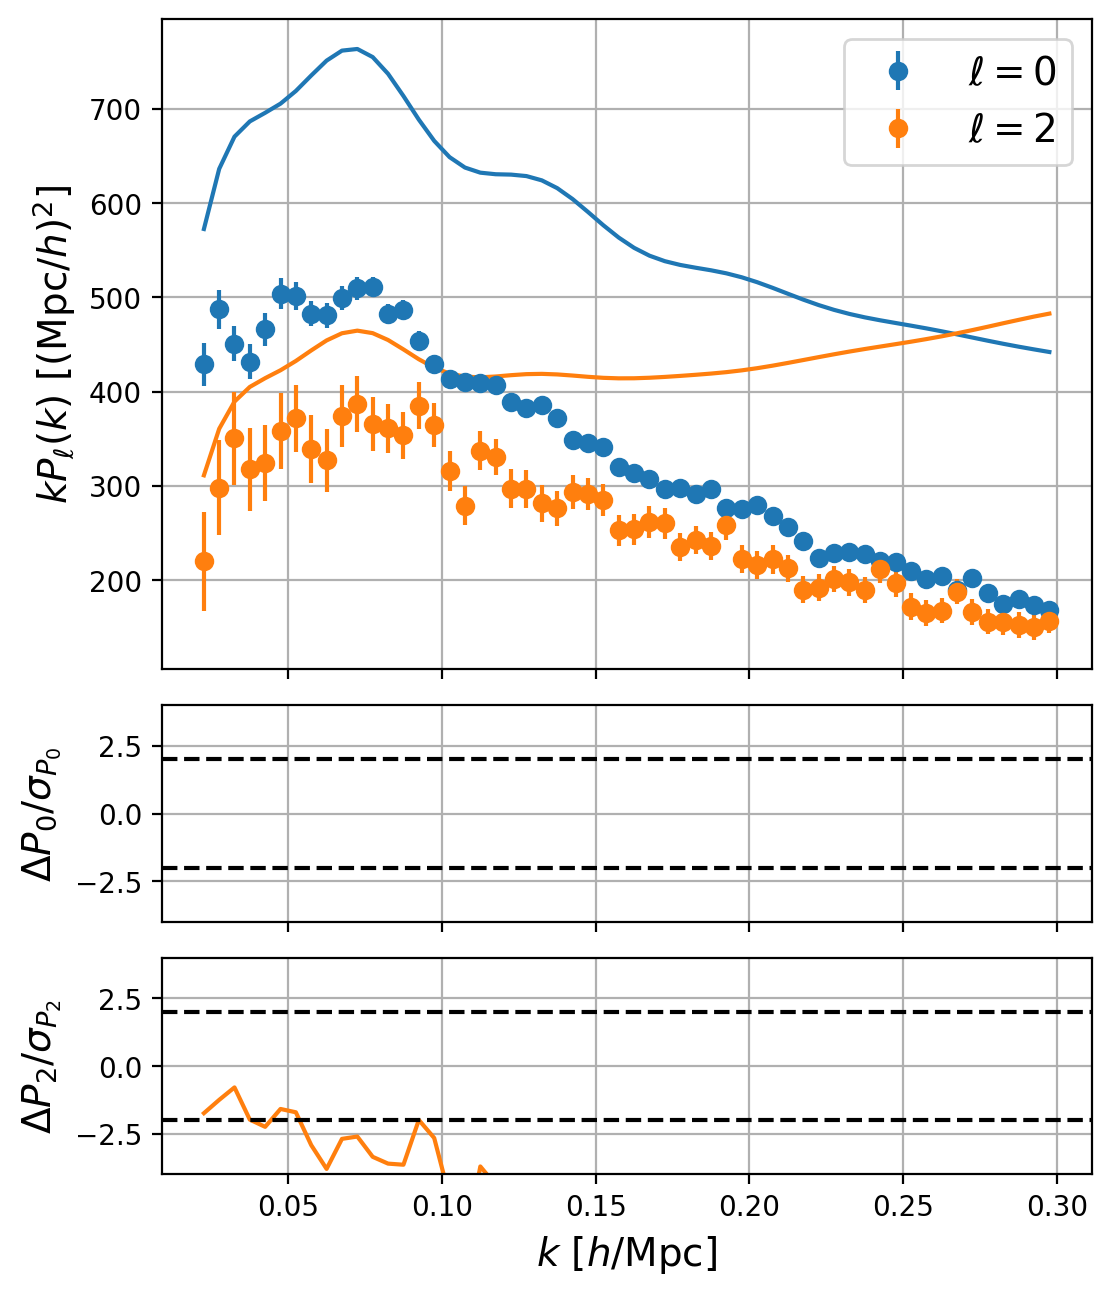

In [4]:
# # set the k bins
# kmin     = 0.02
# kmax     = 0.205
# binning  = 0.005
# k_ev     = np.arange(kmin, kmax, binning)
# klen     = len(k_ev)
# klim     = {ell*2: (kmin,kmax,binning) for ell in range(2)}

# set the k bins
kmin     = 0.0225
kmax     = 0.3
binning  = 0.005
k_ev     = np.arange(kmin, kmax, binning)
klen     = len(k_ev)
klim     = {ell*2: (kmin,kmax,binning) for ell in range(2)}

catas_types = ['','_realistic', '_failures']
catas_type = ''

# load the pk file, the pk calculated from the pkrun.py
pk_fn = pk_dir+f'pkpoles_{tracer}_{region}_{zmin}_{zmax}_default_FKP_lin_thetacut0.05{catas_type}.npy'
wmatrix_fn = pk_dir+f'wmatrix_smooth_{tracer}_{region}_{zmin}_{zmax}_default_FKP_lin_thetacut0.05{catas_type}.npy'

cosmo = DESI()
template = DirectPowerSpectrumTemplate(z=zeff,fiducial='DESI')
theory = FOLPSTracerPowerSpectrumMultipoles(template=template)
print(theory.varied_params)
observable = TracerPowerSpectrumMultipolesObservable(data= pk_fn, 
                                                     klim=klim, 
                                                     covariance = cov_fns,
                                                     theory=theory,
                                                     kin=np.arange(0.001, 0.35, 0.002),
                                                     wmatrix=wmatrix_fn)
likelihood = ObservablesGaussianLikelihood(observable)
likelihood()

fig_pk = observable.plot()

In [5]:
cov = observable.covariance
std = np.sqrt(np.diagonal(cov))

In [6]:
from desilike.emulators import EmulatedCalculator, Emulator, TaylorEmulatorEngine

cosmology = 'LCDM' #LCDM, nuCDM, wCDM
theory_model = 'FOLPS'  # TNS, FOLPS, FOLPSRC, Velocileptors
emulator_fn = f'./results/emulators/emulator_{cosmology}_z{zeff}_{theory_model}.npy'

def initialize_template(redshift, cosmology):
    cosmo = DESI()
    template = DirectPowerSpectrumTemplate(z=redshift, fiducial='DESI')
    if cosmology == 'nuCDM':
        template.init.params['m_ncdm'].update(fixed=False, latex=r'M_\nu', prior = {'limits': [0.0,1.0]})
    elif cosmology == 'nsCDM':
        template.init.params['n_s'].update(fixed=False)
    elif cosmology == 'wCDM':
        template.init.params['w0_fld'].update(fixed=False)
    return template

# os.remove(emulator_fn)
if not os.path.exists(emulator_fn):
    cosmo = DESI()
    template = initialize_template(zeff, cosmology)
    if theory_model =='Velocileptors':
        theory = LPTVelocileptorsTracerPowerSpectrumMultipoles(template=template, k=k_ev)
    if theory_model =='FOLPS':
        theory = FOLPSTracerPowerSpectrumMultipoles(template=template, k=k_ev)
    elif theory_model =='FOLPSRC':
        theory = FOLPSRCTracerPowerSpectrumMultipoles(template=template, k=k_ev)
    print(theory.varied_params)
    # footprint = BoxFootprint(volume=1e10, nbar=1e-3)
    # covariance = ObservablesCovarianceMatrix(cov_fns, footprints=footprint)()
    observable = TracerPowerSpectrumMultipolesObservable(data= pk_fn, 
                                                        klim=klim, 
                                                        covariance = cov_fns,
                                                        theory = theory,
                                                        kin=np.arange(0.001, 0.35, 0.002),
                                                        wmatrix=wmatrix_fn)
    likelihood = ObservablesGaussianLikelihood(observable)
    likelihood()
    emulator = Emulator(theory.pt, engine=TaylorEmulatorEngine(order=3, method='finite')) # Taylor expansion, up to a given order
    emulator.set_samples() # evaluate the theory derivatives (with jax auto-differentiation if possible, else finite differentiation)
    emulator.fit()
    emulator.save(emulator_fn)
    print("Training emmulator finished")

In [7]:
if theory_model =='Velocileptors':
    theory_el = LPTVelocileptorsTracerPowerSpectrumMultipoles(pt=EmulatedCalculator.load(emulator_fn), k=k_ev)
if theory_model =='FOLPS':
    theory_el = FOLPSTracerPowerSpectrumMultipoles(pt=EmulatedCalculator.load(emulator_fn), k=k_ev)
elif theory_model =='FOLPSRC':
    theory_el = FOLPSRCTracerPowerSpectrumMultipoles(pt=EmulatedCalculator.load(emulator_fn), k=k_ev)

print(theory_el(h = 0.7))

[000073.17] [0/1] 12-09 06:51  Emulator                  INFO     Loading ./results/emulators/emulator_LCDM_z0.98_FOLPS.npy.
[[ 4945.11131831 13052.91745437 19169.54278451 23673.77687658
  26882.15540073 29040.29091428 30341.29598916 30945.0335652
  30987.02768137 30584.24299434 29838.35250897 28841.23213375
  27672.75826654 26401.6224269  25085.61501808 23771.51931029
  22496.94294986 21288.56832268 20165.28937155 19139.41893605
  18215.32226841 17392.57403826 16667.78775328 16032.83461132
  15479.27845033 14994.83987673 14569.49273347 14189.75524338
  13844.39190139 13522.24208924 13213.13456961 12908.52497672
  12601.3308744  12286.22912055 11959.49817142 11620.07828422
  11267.39264954 10902.96057076 10530.12888278 10152.21646135
   9773.49693937  9398.62976678  9032.06293837  8678.15639194
   8340.62466224  8022.04860092  7725.03153016  7451.77952224
   7202.28642553  6975.90374263  6772.91496965  6592.62344318
   6432.37727062  6289.67815441  6162.73774246  6049.33183964
   5946.

In [ ]:
from desilike.profilers import MinuitProfiler
from desilike.samples import Profiles

pk_fn = pk_dir+f'pkpoles_{tracer}_{region}_{zmin}_{zmax}_default_FKP_lin_thetacut0.05{catas_type}.npy'
profile_fn = f'./results/profiles/{cosmology}/profile_{tracer}_{region}_z{zeff}{catas_type}.npy'   
 
if os.path.exists(profile_fn): 
    os.remove(profile_fn)
if not os.path.exists(profile_fn):
    observable = TracerPowerSpectrumMultipolesObservable(data= pk_fn, 
                                                        klim=klim, 
                                                        covariance = cov_fns,
                                                        theory=theory_el,
                                                        kin=np.arange(0.001, 0.35, 0.002),
                                                        wmatrix=wmatrix_fn)
    likelihood = ObservablesGaussianLikelihood(observable, theory=theory_el)
    likelihood()
    profiler = MinuitProfiler(likelihood, seed=42)
    profiles = profiler.maximize()
    profiles.save(profile_fn)
print("Profiler finished")
profiles = Profiles.load(profile_fn)
print(profiles.to_stats(tablefmt='pretty'))

[000089.80] [0/1] 12-09 06:51  TracerPowerSpectrumMultipolesObservable INFO     Loading 1 file ['/pscratch/sd/s/shengyu/statistics/ELG_LOPnotqso/pk/pkpoles_ELG_LOPnotqso_GCcomb_0.8_1.1_default_FKP_lin_thetacut0.05.npy'].
[000089.86] [0/1] 12-09 06:51  TracerPowerSpectrumMultipolesObservable INFO     Loading 499 files [/global/cfs/cdirs/desi/survey/catalogs/Y1/mocks/SecondGenMocks/EZmock/desipipe/v1/ffa/2pt/mock1/pk/pkpoles_ELG_LOP_GCcomb_z0.8-1.1_default_FKP_lin_nran10_cellsize6_boxsize9000.npy, ..., /global/cfs/cdirs/desi/survey/catalogs/Y1/mocks/SecondGenMocks/EZmock/desipipe/v1/ffa/2pt/mock100/pk/pkpoles_ELG_LOP_GCcomb_z0.8-1.1_default_FKP_lin_nran10_cellsize6_boxsize9000.npy, ..., /global/cfs/cdirs/desi/survey/catalogs/Y1/mocks/SecondGenMocks/EZmock/desipipe/v1/ffa/2pt/mock199/pk/pkpoles_ELG_LOP_GCcomb_z0.8-1.1_default_FKP_lin_nran10_cellsize6_boxsize9000.npy, ..., /global/cfs/cdirs/desi/survey/catalogs/Y1/mocks/SecondGenMocks/EZmock/desipipe/v1/ffa/2pt/mock298/pk/pkpoles_ELG_LOP_G

[000114.98] [0/1] 12-09 06:52  MeshFFTWindow             INFO     Loading /pscratch/sd/s/shengyu/statistics/ELG_LOPnotqso/pk/wmatrix_smooth_ELG_LOPnotqso_GCcomb_0.8_1.1_default_FKP_lin_thetacut0.05.npy.
[000115.05] [0/1] 12-09 06:52  BaseMatrix                INFO     Loading /pscratch/sd/s/shengyu/statistics/ELG_LOPnotqso/pk/wmatrix_smooth_ELG_LOPnotqso_GCcomb_0.8_1.1_default_FKP_lin_thetacut0.05.npy.
[000120.42] [0/1] 12-09 06:52  ObservablesGaussianLikelihood INFO     Covariance matrix with 112 points built from 499 observations.
[000120.42] [0/1] 12-09 06:52  ObservablesGaussianLikelihood INFO     ...resulting in a Hartlap 2007 factor of 0.7731.
[000120.46] [0/1] 12-09 06:52  ObservablesGaussianLikelihood INFO     Covariance matrix with 112 points built from 499 observations, varying 12 parameters.
[000120.46] [0/1] 12-09 06:52  ObservablesGaussianLikelihood INFO     ...resulting in a Percival 2014 factor of 1.2191.
[000120.52] [0/1] 12-09 06:52  MinuitProfiler            INFO     

[000778.10] [0/1] 12-03 09:19  TracerPowerSpectrumMultipolesObservable INFO     Loading 1 file ['/pscratch/sd/s/shengyu/statistics/ELG_LOPnotqso/pk/pkpoles_ELG_LOPnotqso_GCcomb_0.8_1.1_default_FKP_lin_thetacut0.05_failures.npy'].
[000778.16] [0/1] 12-03 09:19  TracerPowerSpectrumMultipolesObservable INFO     Loading 499 files [/global/cfs/cdirs/desi/survey/catalogs/Y1/mocks/SecondGenMocks/EZmock/desipipe/v1/ffa/2pt/mock1/pk/pkpoles_ELG_LOP_GCcomb_z0.8-1.1_default_FKP_lin_nran10_cellsize6_boxsize9000.npy, ..., /global/cfs/cdirs/desi/survey/catalogs/Y1/mocks/SecondGenMocks/EZmock/desipipe/v1/ffa/2pt/mock100/pk/pkpoles_ELG_LOP_GCcomb_z0.8-1.1_default_FKP_lin_nran10_cellsize6_boxsize9000.npy, ..., /global/cfs/cdirs/desi/survey/catalogs/Y1/mocks/SecondGenMocks/EZmock/desipipe/v1/ffa/2pt/mock199/pk/pkpoles_ELG_LOP_GCcomb_z0.8-1.1_default_FKP_lin_nran10_cellsize6_boxsize9000.npy, ..., /global/cfs/cdirs/desi/survey/catalogs/Y1/mocks/SecondGenMocks/EZmock/desipipe/v1/ffa/2pt/mock298/pk/pkpoles_

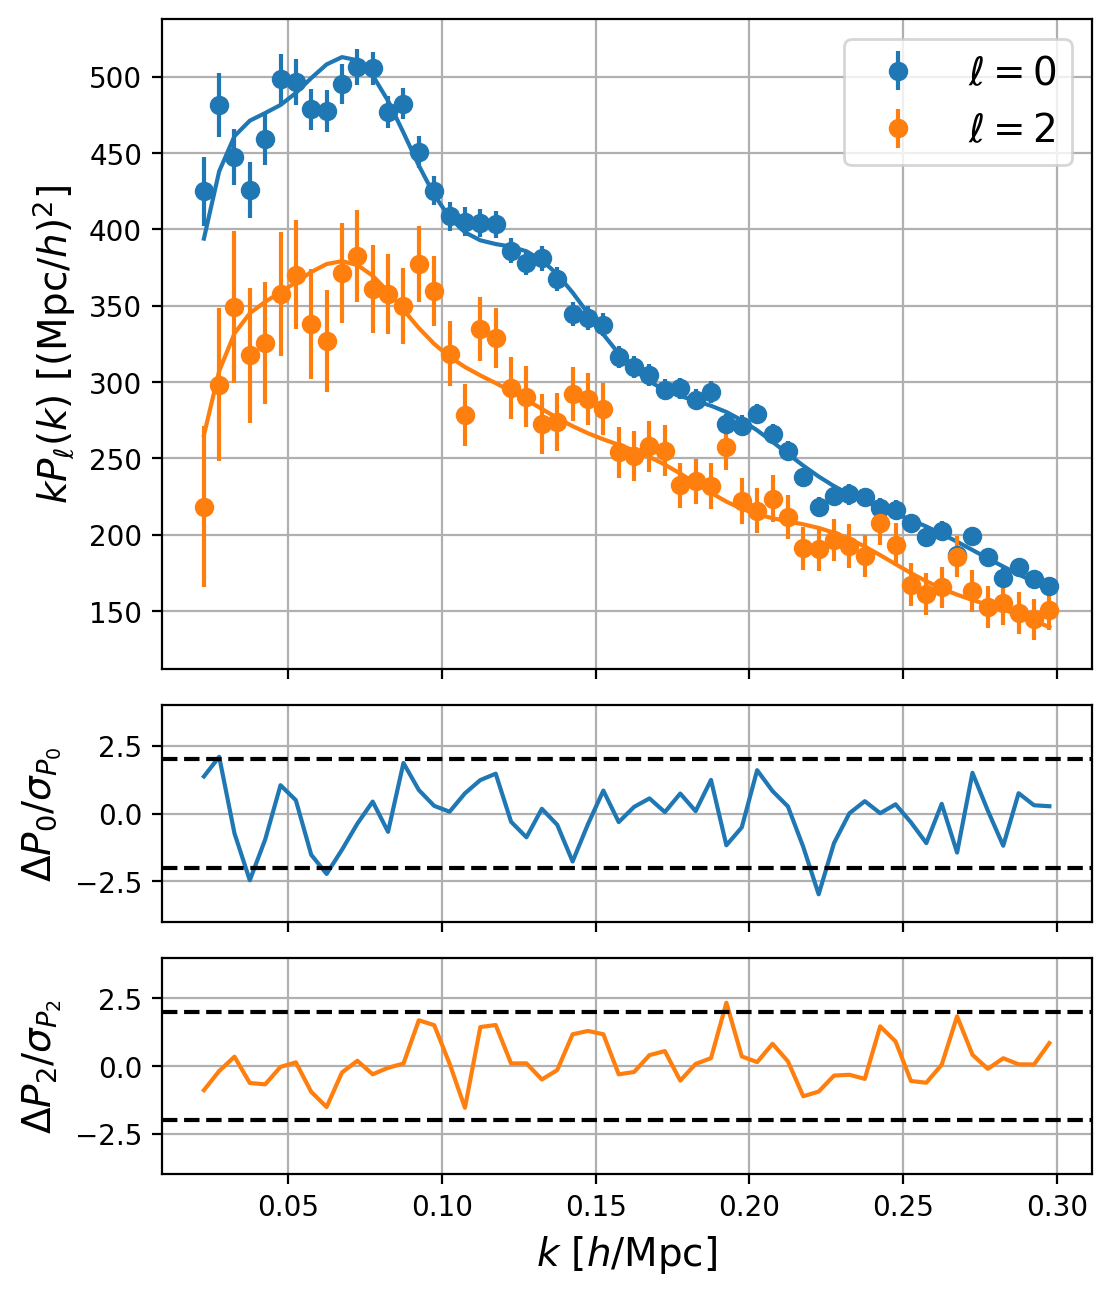

In [31]:
observable = TracerPowerSpectrumMultipolesObservable(data= pk_fn, 
                                                    klim=klim, 
                                                    covariance = cov_fns,
                                                    theory=theory_el,
                                                    kin=np.arange(0.001, 0.35, 0.002),
                                                    wmatrix=wmatrix_fn)
likelihood = ObservablesGaussianLikelihood(observable, theory=theory_el)
print(-2*likelihood(**profiles.bestfit.choice(input=True)))
fig = observable.plot()

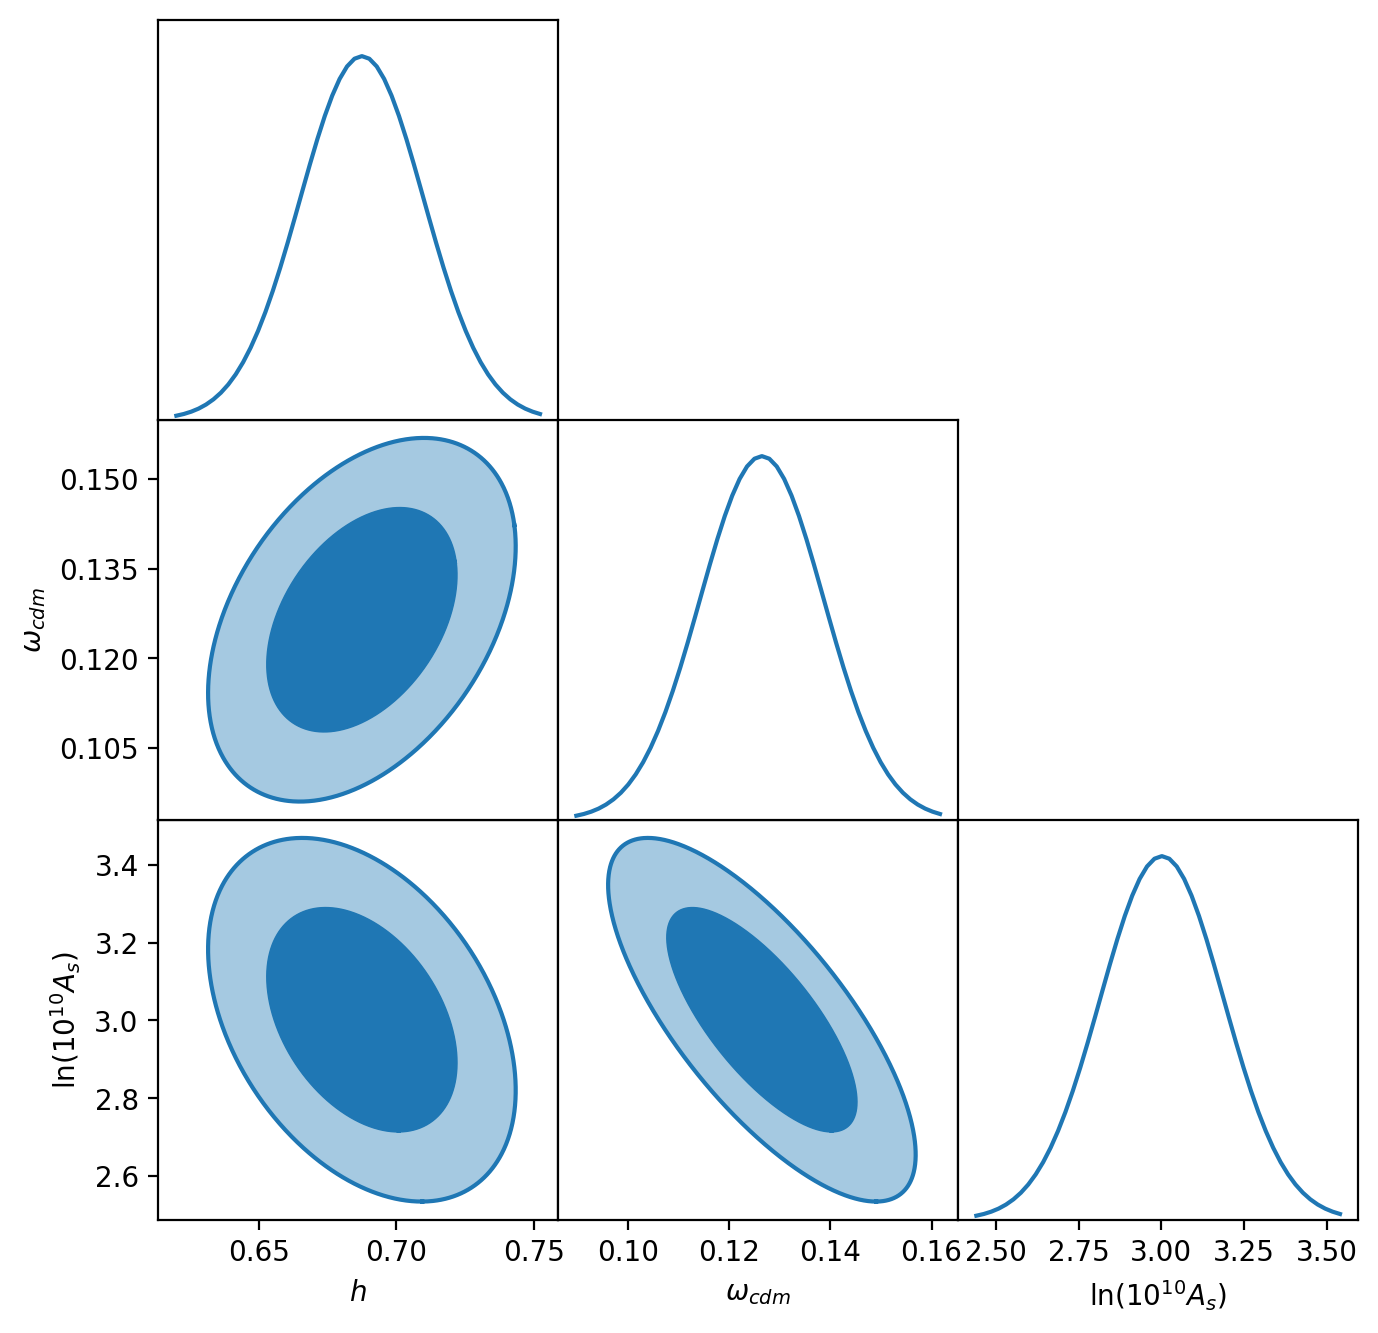

In [32]:
# plot the posterior distribution
from desilike.samples import plotting

fig = plotting.plot_triangle_contours(profiles, params=['h','omega_cdm','logA'], filled=True)

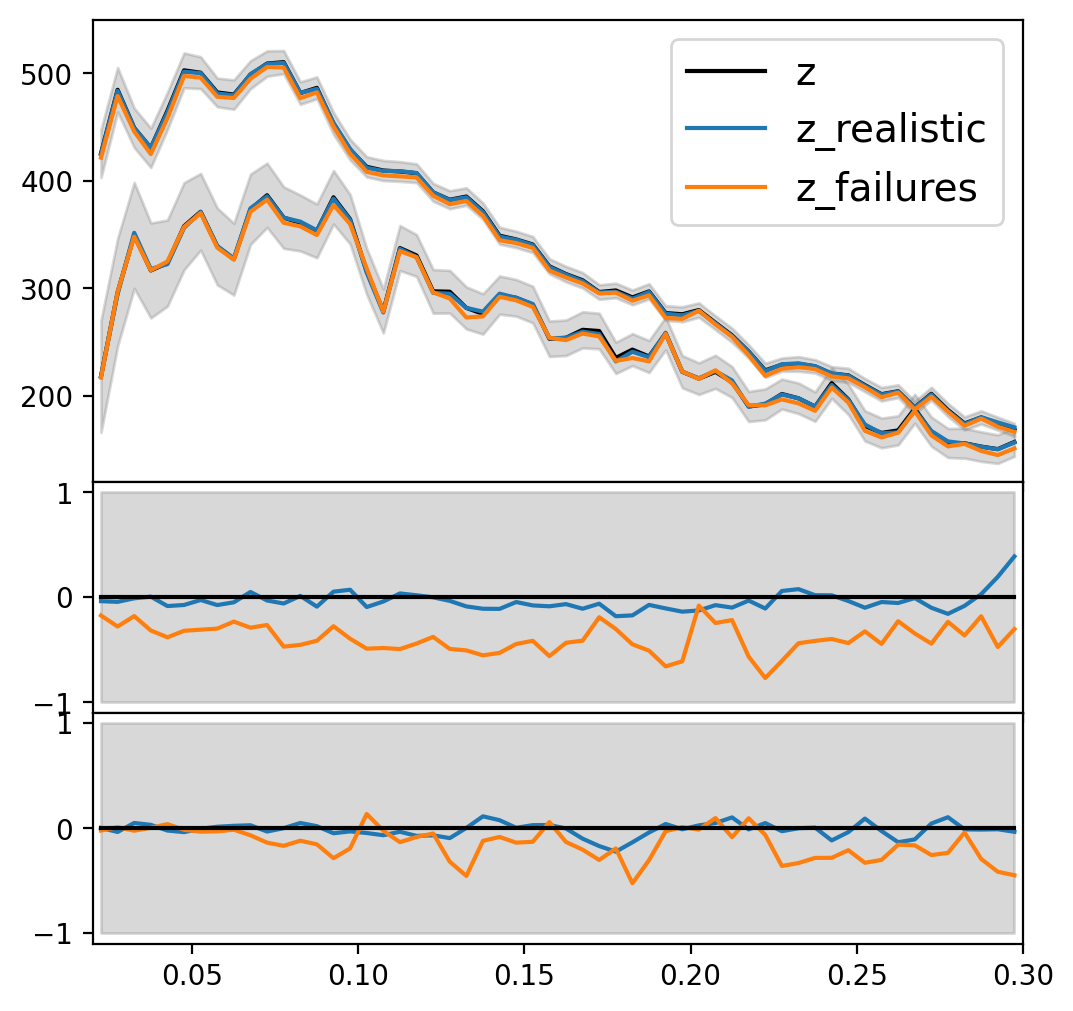

In [34]:
catas_types = ['', '_realistic', '_failures']
labels = ['z', 'z_realistic','z_failures']
colors = ['black', 'C0', 'C1']

fig, ax = plt.subplots(3,1, figsize = (6,6), gridspec_kw={'height_ratios': [2, 1, 1], 'hspace': 0}, sharex=True)
for i, catas_type in enumerate(catas_types):
    catas_fn = pk_dir+f'pkpoles_{tracer}_{region}_{zmin}_{zmax}_default_FKP_lin5_thetacut0.05{catas_type}.txt'
    catas_pkl = np.loadtxt(catas_fn, dtype=complex)
    k = np.real(catas_pkl[:,1])[4:60]
    pk0 = np.real(catas_pkl[:,3])[4:60]
    pk2 = np.real(catas_pkl[:,4])[4:60]
    if i ==0:
        pk0_fiducial = pk0
        pk2_fiducial = pk2
        ax[0].plot(k, k*(pk0), label= 'z', color=colors[i])
        ax[0].plot(k, k*(pk2), color=colors[i])
        ax[0].fill_between(k, k*(pk0-std[:56]), k*((pk0)+std[:56]), color='grey', alpha=0.3)
        ax[0].fill_between(k, k*(pk2-std[56:112]), k*((pk2)+std[56:112]), color='grey', alpha=0.3)

    if i>0:
        ax[0].plot(k, k*(pk0), color=colors[i], label= labels[i])
        ax[0].plot(k, k*(pk2), color=colors[i])
        # ax[1].plot(k, pk0/pk0_fiducial, color=colors[i])
        # ax[2].plot(k, pk2/pk2_fiducial, color=colors[i])
        ax[1].plot(k, (pk0- pk0_fiducial)/std[:56], color=colors[i])
        ax[2].plot(k, (pk2 - pk2_fiducial)/std[56:112], color=colors[i])
        ax[i].plot(k, [0]*len(k), color='black', ls='-')
        ax[i].fill_between(k, -1, +1, color='grey', alpha=0.3)

    ax[0].legend()
    ax[0].set_ylim([120,550])
    # ax[i].grid(True)
    # plt.plot(k, k*pk2, label = sys_types[i])
plt.xlim([0.02,0.30])
plt.show()